# Autoencoder

Autoencoders are neural networks that have the ability to discover low- dimensional representations of high-dimensional data and are able to reconstruct the input from the output.

Autoencoders are made up of two pieces of the neural network, an encoder and
a decoder. The encoder reduces the dimensionality of a high dimensional dataset to a low dimensional one whereas a decoder essentially expands the low-dimensional data to high-dimensional data.

The goal of such a process is to try to reconstruct the original input. If the neural network is good, then there is a good chance of reconstructing the original input from the encoded data. This inherent principle is critical in building an anomaly detection module.

Note that autoencoders are not that great if you have training samples containing few dimensions/features at each input point. Autoencoders perform well for five or more dimensions. 

## autoencoder model

an autoencoder neural network is actually a pair of two connected sub-networks, an encoder and a decoder. An encoder network takes in an input and converts it into a smaller, dense representation, also known as a latent representation of the input, which the decoder network can then use to convert it back to the original input as much as possible

Autoencoders use data compression logic where the compression and decompression functions implemented by the neural networks are lossy and are mostly unsupervised without much intervention

The entire network is usually trained as a whole. The loss function is usually either the mean-squared error or cross-entropy between the output and the input, known as the reconstruction loss, which penalizes the network for creating outputs different from the input. 

Since the encoding (which is simply the output of the hidden layer in
the middle) has far less units than the input, the encoder must choose to discard information

The encoder learns to preserve as much of the relevant information as
possible in the limited encoding and intelligently discards the irrelevant parts. The decoder learns to take the encoding and properly reconstruct it back into the input.

Why do we even bother learning the presentation of the original input only to
reconstruct the output as well as possible? The answer is that when we have input with many features, generating a compressed representation via the hidden layers of the neural network could help in compressing the input of the training sample. 

So when the neural network goes through all the training data and fine tunes the weights of all the hidden layer nodes, what will happen is that the weights will truly represent the kind of input that we typically see.

if we try to input some other type of data, such as having data with some noise, the autoencoder network will be able to detect the noise and remove at least some portion of the noise when generating the output

The logic behind the denoising autoencoder that if we have trained our encoder
on good, normal images and the noise when it comes as part of the input is not really a salient characteristic, it is possible to detect and remove such noise

# Library

In [1]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [40]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,scoring,fe,anomaly_detection

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [5]:
filePath = f'E:/gitlab/machine-learning/dataset/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [29]:
describe.vc(df,'Class')

0    20000
1      400
Name: Class, dtype: int64

# split data

In [21]:
x_train1, x_test, y_train1, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1), df['Class'], test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_val.shape, 'validation samples')
print(x_test.shape, 'test samples')

(13056, 29) train samples
(3264, 29) validation samples
(4080, 29) test samples


# model

In [44]:
autoencoder = anomaly_detection.model_autoencoder(x_train,16)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_28 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_29 (Dense)             (None, 29)                493 

In [45]:
NAME = "deepautoencoder"

In [46]:
batch_size = 32
epochs = 20
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME),profile_batch = 100000000)

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_val, x_val),
                    callbacks=[tensorboard])

Train on 13056 samples, validate on 3264 samples
Epoch 1/20
13056/13056 [==============================] - 3s 201us/sample - loss: 1.4819 - mae: 0.6792 - accuracy: 0.1839 - val_loss: 1.5391 - val_mae: 0.6721 - val_accuracy: 0.4056
Epoch 2/20
13056/13056 [==============================] - 2s 164us/sample - loss: 1.4309 - mae: 0.6585 - accuracy: 0.4428 - val_loss: 1.5251 - val_mae: 0.6658 - val_accuracy: 0.4415
Epoch 3/20
13056/13056 [==============================] - 2s 165us/sample - loss: 1.4235 - mae: 0.6556 - accuracy: 0.4724 - val_loss: 1.5213 - val_mae: 0.6644 - val_accuracy: 0.4657
Epoch 4/20
13056/13056 [==============================] - 2s 158us/sample - loss: 1.4210 - mae: 0.6547 - accuracy: 0.4850 - val_loss: 1.5199 - val_mae: 0.6639 - val_accuracy: 0.4733
Epoch 5/20
13056/13056 [==============================] - 2s 190us/sample - loss: 1.4199 - mae: 0.6544 - accuracy: 0.4940 - val_loss: 1.5196 - val_mae: 0.6638 - val_accuracy: 0.4740
Epoch 6/20
13056/13056 [=================

# evaluate

In [47]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4080/4080 [==============================] - 0s 100us/sample - loss: 1.4101 - mae: 0.6599 - accuracy: 0.5647
Test loss: 1.4101168066847558
Test accuracy: 0.6598637


# calculate error

In [50]:
y_label,error = anomaly_detection.calculate_error(autoencoder,x_test,15.00)

In [51]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.63      0.56      0.59        93

    accuracy                           0.98      4080
   macro avg       0.81      0.78      0.79      4080
weighted avg       0.98      0.98      0.98      4080



In [52]:
roc_auc_score(y_test, y_label)

0.7756822576599757

comfusion matrix = 
[[3956   31]
 [  41   52]]

accuracy_score =  0.9824
balanced_accuracy_score =  0.7757

precision score =  0.6265
average precision score =  0.3604
recall score =  0.5591

F1 score =  0.5909
F2 score =  0.6118
F3 score =  0.619
F_beta score =  0.619
Matthews Correlation Coefficient score =  0.5829

AUC of Precision-Recall Curve on Testing =  0.5978
Best Threshold for Precision-Recall Curve = 1.000000
F-Score = 0.591
AUC of ROC =  0.7757

Best Threshold for ROC = 1.000000
G-Mean = 0.745
Best Threshold with Youden’s J statistic = 1.000000

Cohens kappa =  0.5819
Gini =  0.1957

Expected Approval Rate =  0.0203
Expected Default Rate =  0.3735

classification_report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.63      0.56      0.59        93

    accuracy                           0.98      4080
   macro avg       0.81      0.78      0.79      4080
weighted avg       0.98      0.98    

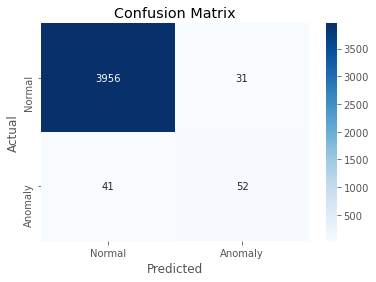

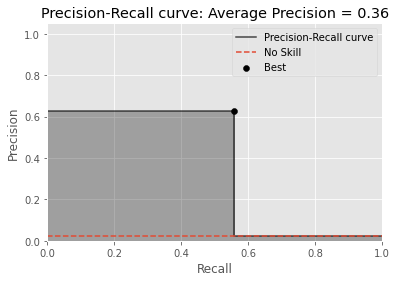

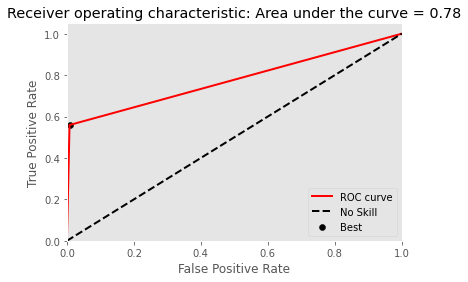


time span=  1


In [53]:
scoring.print_score(y_test,y_label,y_label,labels=["Normal", "Anomaly"])

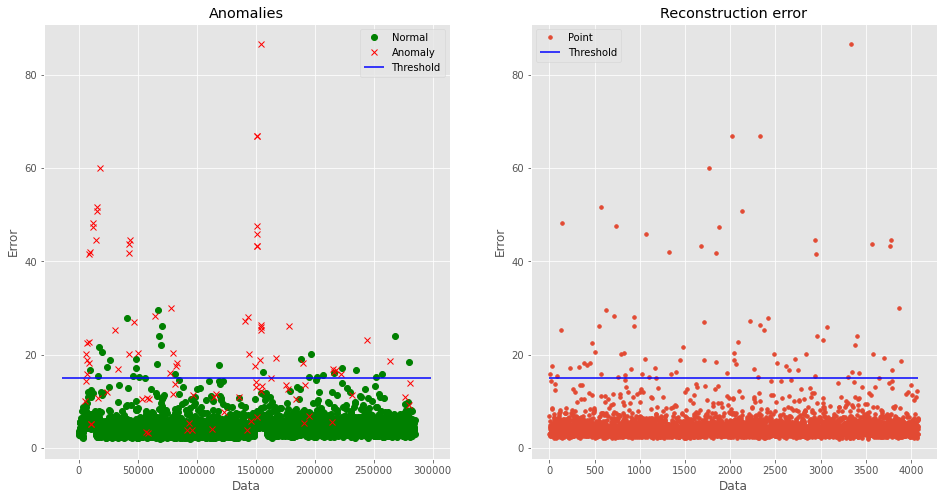

In [55]:
anomaly_detection.draw_anomaly(y_test, error, threshold)